# Get Official CPI and Inflation Rate Data

                CPI  MoM_Inflation  YoY_Inflation
Date                                             
2021-01-01  261.582            NaN            NaN
2021-02-01  263.014       0.547438            NaN
2021-03-01  264.877       0.708327            NaN
2021-04-01  267.054       0.821891            NaN
2021-05-01  269.195       0.801711            NaN
2021-06-01  271.696       0.929066            NaN
2021-07-01  273.003       0.481052            NaN
2021-08-01  273.567       0.206591            NaN
2021-09-01  274.310       0.271597            NaN
2021-10-01  276.589       0.830812            NaN
2021-11-01  277.948       0.491343            NaN
2021-12-01  278.802       0.307252            NaN
2022-01-01  281.148       0.841457       7.479872
2022-02-01  283.716       0.913398       7.871064
2022-03-01  287.504       1.335138       8.542456
2022-04-01  289.109       0.558253       8.258629
2022-05-01  292.296       1.102352       8.581512
2022-06-01  296.311       1.373608       9.059758


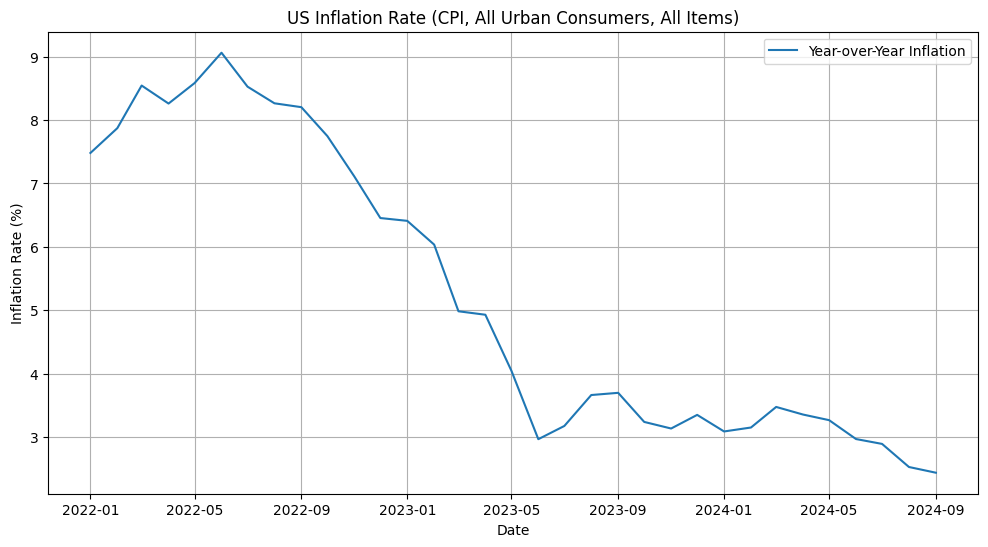

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# BLS API endpoint
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# Series ID for CPI (All Urban Consumers, All Items, Not Seasonally Adjusted)
series_id = 'CUUR0000SA0'

# API request parameters
data = json.dumps({
    "seriesid": [series_id],
    "startyear": "2021",
    "endyear": "2024",
    "registrationkey": "d7ba76b4ba7b4f0fbec2d1d704a819d1"  # Replace with your BLS API key
})

# Send request to BLS API
headers = {'Content-type': 'application/json'}
response = requests.post(url, data=data, headers=headers)

# Parse the JSON response
json_data = json.loads(response.text)

# Extract the data series
series = json_data['Results']['series'][0]

# Create a list of dictionaries with the data
data_list = []
for item in series['data']:
    year = int(item['year'])
    month = int(item['period'][1:])  # Remove 'M' prefix from month
    date = datetime(year, month, 1)
    value = float(item['value'])
    data_list.append({'Date': date, 'CPI': value})

# Create a DataFrame
df = pd.DataFrame(data_list)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Calculate month-over-month inflation rate
df['MoM_Inflation'] = df['CPI'].pct_change() * 100

# Calculate year-over-year inflation rate
df['YoY_Inflation'] = df['CPI'].pct_change(periods=12) * 100

# Display the data
print(df)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['YoY_Inflation'], label='Year-over-Year Inflation')
plt.title('US Inflation Rate (CPI, All Urban Consumers, All Items)')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


# Filter on Sample Period (Nov 2021 to Feb 2022) 

In [2]:
start_date = '2021-11-01'
end_date = '2022-02-01'
filtered_df = df.loc[start_date:end_date]
filtered_df

,CPI,MoM_Inflation,YoY_Inflation
Date,,,
2021-11-01,277.948,0.491343,NaN
2021-12-01,278.802,0.307252,NaN
2022-01-01,281.148,0.841457,7.479872
2022-02-01,283.716,0.913398,7.871064


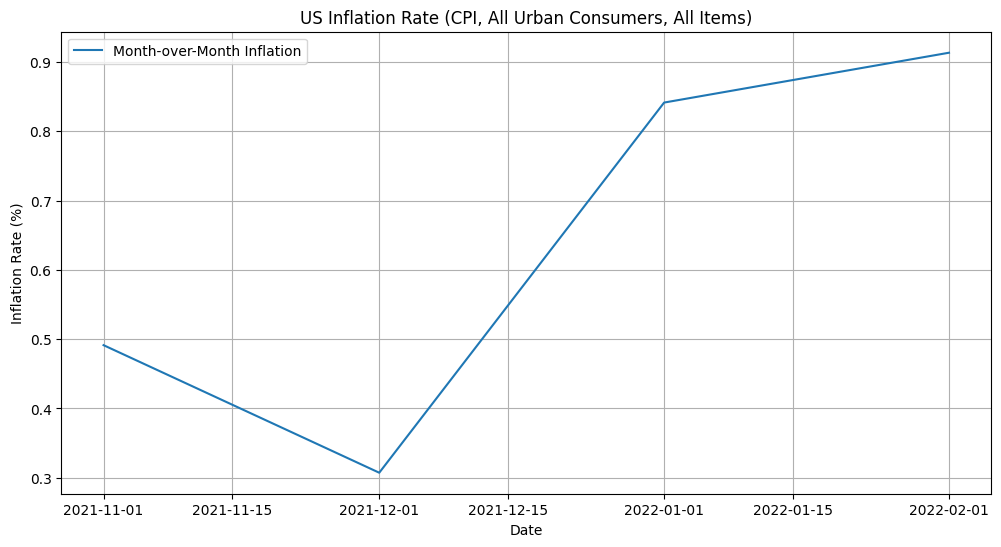

In [3]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(filtered_df.index, filtered_df['MoM_Inflation'], label='Month-over-Month Inflation')
plt.title('US Inflation Rate (CPI, All Urban Consumers, All Items)')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


# Get User Reported Inflation Data

In [4]:
import os
import asyncio
from sqlalchemy import text
from dotenv import load_dotenv
from urllib.parse import urlparse
from sqlalchemy.ext.asyncio import create_async_engine
import pandas as pd
import nest_asyncio
import numpy as np

load_dotenv()

# Apply nest_asyncio
nest_asyncio.apply()

def run_query(query):
    tmpPostgres = urlparse(os.getenv("DATABASE_URL"))

    async def async_run():
        engine = create_async_engine(
            f"postgresql+asyncpg://{tmpPostgres.username}:{tmpPostgres.password}@{tmpPostgres.hostname}{tmpPostgres.path}?ssl=require", 
            echo=True
        )
        
        # Debug: Check connection string
        print(f"Connecting to database at: {tmpPostgres.hostname}")

        async with engine.connect() as conn:
            print("Executing query...")
            result = await conn.execute(text(query))
            rows = result.fetchall()  # This should not be awaited
            
            # Debug: Print the fetched rows
            print(f"Rows fetched: {rows}")

        await engine.dispose()
        return rows

    # Directly run the async function
    return asyncio.run(async_run())

# # Test query
# query = "SELECT 1;"
# result = run_query(query)

query = f"""
select * FROM money_diaries.analytics_categories_over_time
"""

# Execute the query and convert the results to a Pandas DataFrame
df = pd.DataFrame(run_query(query))
df['published_date'] = pd.to_datetime(df['published_date'])
col_names = ['published_date', 'food_drink', 'entertainment', 'home_health', 'clothes_beauty', 'transportation', 'other']
df = df[col_names]
df['month'] = df['published_date'].dt.to_period('M')
print(df)

Connecting to database at: ep-lucky-fog-a8loq2jv.eastus2.azure.neon.tech
2024-10-26 12:55:54,933 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2024-10-26 12:55:54,935 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-10-26 12:55:55,326 INFO sqlalchemy.engine.Engine select current_schema()
2024-10-26 12:55:55,326 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-10-26 12:55:55,768 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2024-10-26 12:55:55,768 INFO sqlalchemy.engine.Engine [raw sql] ()
Executing query...
2024-10-26 12:55:56,268 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-10-26 12:55:56,268 INFO sqlalchemy.engine.Engine 
select * FROM money_diaries.analytics_categories_over_time

2024-10-26 12:55:56,269 INFO sqlalchemy.engine.Engine [generated in 0.00099s] ()
Rows fetched: [(datetime.date(2021, 12, 20), 23, 'new york, ny', 190.52, 15.0, None, 298.4, 35.73, None), (datetime.date(2021, 12, 3), 31, 'new york, ny', 104.01, None, None, 103.97, 2.75, 35.9

In [5]:
# Step 1: Convert 'published_date' to datetime
df['published_date'] = pd.to_datetime(df['published_date'])

# Step 2: Set 'published_date' as the index
df.set_index('published_date', inplace=True)
df.drop(['month'], axis=1, inplace=True)

# Step 3: Group by year and month, then calculate the mean
monthly_means = df.resample('M').mean()


/tmp/ipykernel_2285163/2817814403.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df.resample('M').mean()


# Calculate Weights

In [8]:
def calculate_expenditure_weights(household_data):
    """
    Calculate consumer expenditure weights based on household survey data
    Parameters:
    household_data (DataFrame): Survey data of household spending by category
    Returns:
    DataFrame with calculated weights and summary statistics
    """
    def calculate_relative_importance(data):
        # Calculate percentage of total expenditure for each category
        total_spending = data.sum()
        return (data / total_spending * 100).round(2)
    # Calculate average spending per household
    avg_spending = household_data.mean()
    # Calculate weights (relative importance)
    weights = calculate_relative_importance(avg_spending)
    # Calculate standard error to show variation in spending patterns
    std_error = household_data.std() / np.sqrt(len(household_data))
    # Combine results
    results = pd.DataFrame({
        'Average_Annual_Spending': avg_spending.round(2),
        'Weight_Percentage': weights,
        'Std_Error': std_error.round(2)
    })
    return results

# Calculate weights
results = calculate_expenditure_weights(df[['food_drink', 'entertainment', 'home_health', 'clothes_beauty', 'transportation', 'other']])
sorted_results = results.sort_values('Weight_Percentage', ascending=False)

# Get weights from sorted_results (converting from percentage back to decimal)
weights = sorted_results['Weight_Percentage'] / 100

# Calculate Inflation Rate on User Reported Expenses

In [9]:
# Calculate CPI
def calculate_simple_cpi(price_data, weights):
    """
    Calculate CPI using weights and price data
    """
    # Create empty DataFrame for results
    results = pd.DataFrame(index=price_data.index)
    # Calculate weighted prices for each year
    weighted_prices = price_data.multiply(weights)
    # Calculate CPI (sum of weighted prices divided by base year sum, times 100)
    base_year_weighted_sum = weighted_prices.iloc[0].sum()
    results['CPI'] = (weighted_prices.sum(axis=1) / base_year_weighted_sum) * 100
    # Calculate inflation rate
    results['Inflation_Rate'] = results['CPI'].pct_change()
    return results

cpi_results = calculate_simple_cpi(monthly_means, weights)
cpi_results

,CPI,Inflation_Rate
published_date,,
2021-11-30,100.000000,NaN
2021-12-31,215.047902,1.150479
2022-01-31,244.212448,0.135619
2022-02-28,166.577430,-0.317900


# Modify Official Sample Index

In [10]:
# Step 3: Reindex the official DataFrame to align with the user-reported dates
# Forward-fill to get official CPI on last day of month
official_cpi_df = filtered_df.reindex(cpi_results.index, method='ffill')
official_cpi_df

,CPI,MoM_Inflation,YoY_Inflation
published_date,,,
2021-11-30,277.948,0.491343,NaN
2021-12-31,278.802,0.307252,NaN
2022-01-31,281.148,0.841457,7.479872
2022-02-28,283.716,0.913398,7.871064


# Plot Line Chart

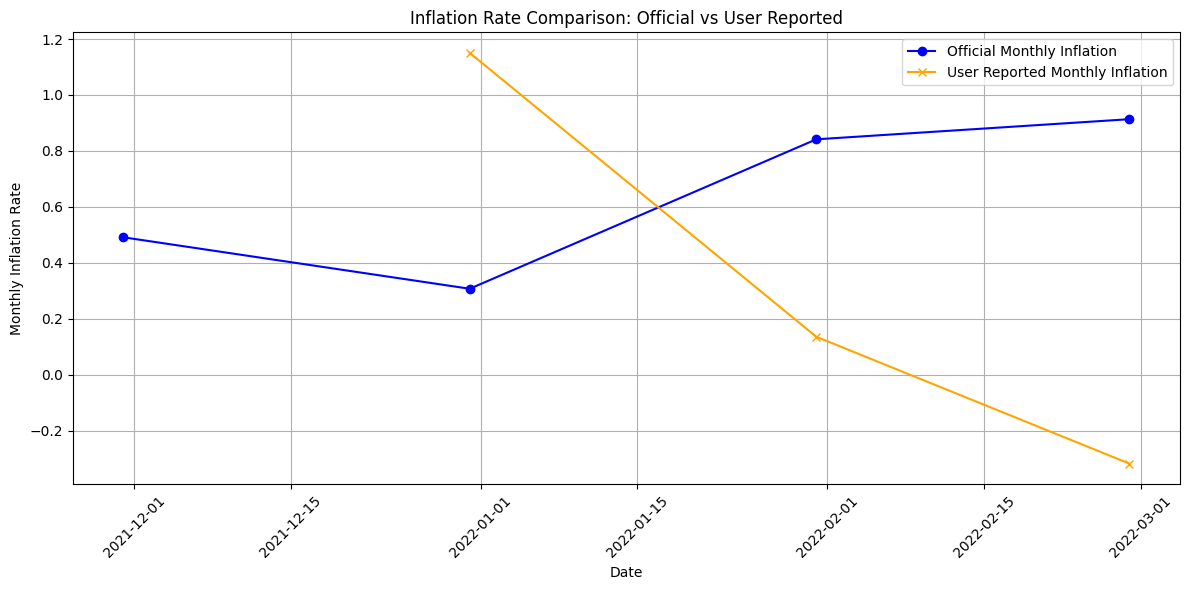

In [11]:
# Step 4: Plot the data
plt.figure(figsize=(12, 6))
plt.plot(official_cpi_df.index, official_cpi_df['MoM_Inflation'], marker='o', label='Official Monthly Inflation', color='blue')
plt.plot(cpi_results.index, cpi_results['Inflation_Rate'], marker='x', label='User Reported Monthly Inflation', color='orange')

# Step 5: Customize the chart
plt.title('Inflation Rate Comparison: Official vs User Reported')
plt.xlabel('Date')
plt.ylabel('Monthly Inflation Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

# Step 6: Show the chart
plt.show()